# Semantic_Image_Search
[source](https://github.com/emily-gibbs/articles/blob/main/image_semantic_search_with_vectors/code_walkthrough.ipynb)

Have you ever taken forever trying to find a specific photo in a photo folder? Or tried to search an image repository for just the right image for a presentation and can't seem to find what you're looking for? It may be that the technology underlying your image search is based on outdated methods. 

The most straightforward and traditional way to perform an image search is with tags - each image is assigned relevant tags, and when someone searches the tag those images are returned. However, there are several problems with this approach:

Can't handle synonyms - what if the tag is 'funny', but the user searches with 'silly'? It would be very hard to tag an image with ALL of the ways a user could phrase their search. 
No sense of degree - with thousands of images, a user would likely prefer to see images ranked by how closely they match the query (e.g. from most silly to least silly)
Time consuming - It takes time and effort to make sure all images are correctly tagged and that relevant tags are assigned when new images are added. 
What a user really wants is to be able to search based upon meaning, not a finite set of words. This is where vectors embeddings come to the rescue! 🥳

a vector embedding is a list of numbers that represents features of something. They represent the semantic meaning of unstructured data such as chunks of text, images, videos, etc. We can measure how similar two vectors are (are therefore how similar their source objects are) with the cosine similarity formula.

What if we leveraged this idea for an image search? Remember - once an object is embedded into the meaning space it doesn't matter what form it took before (text, image, audio, etc.). The only thing that matters is it's meaning. So if we create vectors for all of our images, then create a vector for our search text, we should be able to use cosine similarity to compare them and find what images best match our search!

Sound kind of confusing? Let's walk through the code implementation step-by-step so we can see what a proof of concept of this would look like.

First, we must ensure that the image embeddings and the text embeddings are in the same meaning space. This is important! Models that create vector embeddings from inputs each create their own unique meaning space. This is because the features of the vector are unique to the model (and the number of features may be different too!). We can't just embed an image with a random image model then embed our search text with a different random text model and compare the two to each other -even if they did have the same number of features, its like comparing apples to orangutans and you'll get back nonsense results!

Fortunately there are models that have been trained on multiple input modalities and embed them into the same meaning space. The one we'll be using today is called [OpenCLIP](https://huggingface.co/docs/hub/en/open_clip), an open-source implementation of the CLIP model created by OpenAI. 

OpenCLIP actually has several model versions that you can load and use. We'll be using the "ViT-g-14" model for this tutorial, but I encourage you to explore the other models that are available. 

Let's start by installing some libraries:

In [ ]:

!pip install -qU pip
!pip install -qU openai
!pip install -qU google-genai
!pip install python-dotenv
!pip install pdf2image
!pip install -q langchain
!pip install -q langchain-experimental
!pip install -qU matplotlib

!pip install open_clip_torch

In [2]:
import os
import io
import time
from dotenv import load_dotenv
import base64
import requests
import textwrap
#from pdf2image import convert_from_path
import PIL

from IPython.display import Image, Audio, Markdown, Math

import openai
from google import genai

load_dotenv("../../.env", override=True)

from langchain_experimental.open_clip import OpenCLIPEmbeddings # requires that open_clip_torch is installed
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

#### Loading model using LangChain wrapper

In [3]:
model_name = "ViT-g-14"
checkpoint = "laion2b_s34b_b88k"
clip_embd = OpenCLIPEmbeddings(model_name=model_name, checkpoint=checkpoint)

Now we need to create a vector embedding for all of the images that we want to search. I have a folder of ~40 bird images in a folder simply called "Images" that you can find at the Github repo for this project, or you can use your own set of images. Below is a function to create an embedding for each image in our folder and store them in a JSON file:

In [5]:
"""
Create a JSON file with data in the format of
{
    image_uri: 
        'embedding': image_vector
}
"""
def embed_all_images(images_dir: str):

    # Check if we already have some image vectors made (if we do, don't want to remake them every time we add a new image)
    old_image_vectors = {}
    if os.path.exists('image_vectors.json'):
        with open('image_vectors.json', 'r') as file:
            old_image_vectors = json.load(file)

    image_files = os.listdir(images_dir)
    image_uris = [os.path.join(images_dir, image_file) for image_file in image_files if image_file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]
    new_image_vectors = {}
    for image_uri in image_uris:
        print(f"Embedding image {image_uri}")
        if image_uri in old_image_vectors:
            # Reuse the vector embedding created before
            new_image_vectors[image_uri] = old_image_vectors[image_uri]
        else:
            # Create the vector embedding for this image
            image_vector = clip_embd.embed_image([image_uri])[0]
            new_image_vectors[image_uri] = {'embedding': image_vector}

    # Write the dictionary to a JSON file
    with open('image_vectors.json', 'w') as file:
        json.dump(new_image_vectors, file, indent=4)

embed_all_images(images_dir = "../../Data/RAG_images/")
print(f"{len(json.load(open('image_vectors.json')))} images embedded")

Embedding image ../../Data/RAG_images/OIP (1).jpg
Embedding image ../../Data/RAG_images/owl-6884773_640.jpg
Embedding image ../../Data/RAG_images/eagle-377202_640.jpg
Embedding image ../../Data/RAG_images/OIP.jpg
Embedding image ../../Data/RAG_images/Ramphastos_vitellinus_-Birds_of_Eden,_South_Africa-8a.jpg
Embedding image ../../Data/RAG_images/gosling-7938445_640.jpg
Embedding image ../../Data/RAG_images/peafowl-816981_640.jpg
Embedding image ../../Data/RAG_images/tucan-743047_640.jpg
Embedding image ../../Data/RAG_images/bird-7116272_640.jpg
Embedding image ../../Data/RAG_images/chicken-3741129_640.jpg
Embedding image ../../Data/RAG_images/bird-7917250_640.jpg
Embedding image ../../Data/RAG_images/vulture-2441638_640.jpg
Embedding image ../../Data/RAG_images/Ramphastos_vitellinus_-Matsue_Vogel_Park-8a-4c.jpg
Embedding image ../../Data/RAG_images/1548d06a49fccb050deaf74b443a0a59.jpg
Embedding image ../../Data/RAG_images/600px-Tucano-de-bico-preto_do_Parque_Nacional_da_Amazônia.jpg
Emb

Loading the JSON file for use with the rest of the code:

In [6]:
# Load the image vectors from the JSON file
with open(file="./image_vectors.json", mode='r') as file:
    image_data = json.load(file)

Now we need a function that allows us to pass in a search text and get back the images that best fit that search. It must:

+ Create the vector embedding for the search text
+ Calculate the cosine similarity between that search text and all of the image vector embeddings
+ Return the images that are most similar to that search vector


Here's the code for that below. We're actually going to create the search vector outside of this function (we'll see why in just a bit…):

In [7]:
def display_top_search_results(
    query_vector: list[float], image_data: dict[str, list[float]], num_results: int = 5
):

    # Calculate the cosine similarity between the query vector and all image vectors and add that to the image_info dict
    for image_uri, data in image_data.items():
        similarity = cosine_similarity(
            np.array([query_vector]), np.array([data["embedding"]])
        )[0][0]
        data["query_similarity"] = similarity

    # Sort the image_info dict by the similarity value and return the top num_results
    top_results = dict(
        sorted(
            image_data.items(),
            key=lambda item: item[1]["query_similarity"],
            reverse=True,
        )[:num_results]
    )
    
    # Display the images with their scores in a grid with 3 columns
    # Calculate number of rows and columns needed
    num_cols = 3
    num_rows = (num_results + num_cols - 1) // num_cols  # Ceiling division

    # Create subplot grid
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
    axs = axs.ravel()  # Flatten the 2D array of axes to make indexing easier

    # Display images
    for i, (image_uri, data) in enumerate(top_results.items()):
        axs[i].imshow(PIL.Image.open(image_uri))
        axs[i].set_title(f"Score: {data['query_similarity']:.2f}")
        axs[i].axis("off")

    # Hide any empty subplots
    for j in range(i + 1, len(axs)):
        axs[j].axis("off")

    plt.tight_layout()
    plt.show()

Let's test this out by asking for the top 3 images that match the search for a 'funny bird':

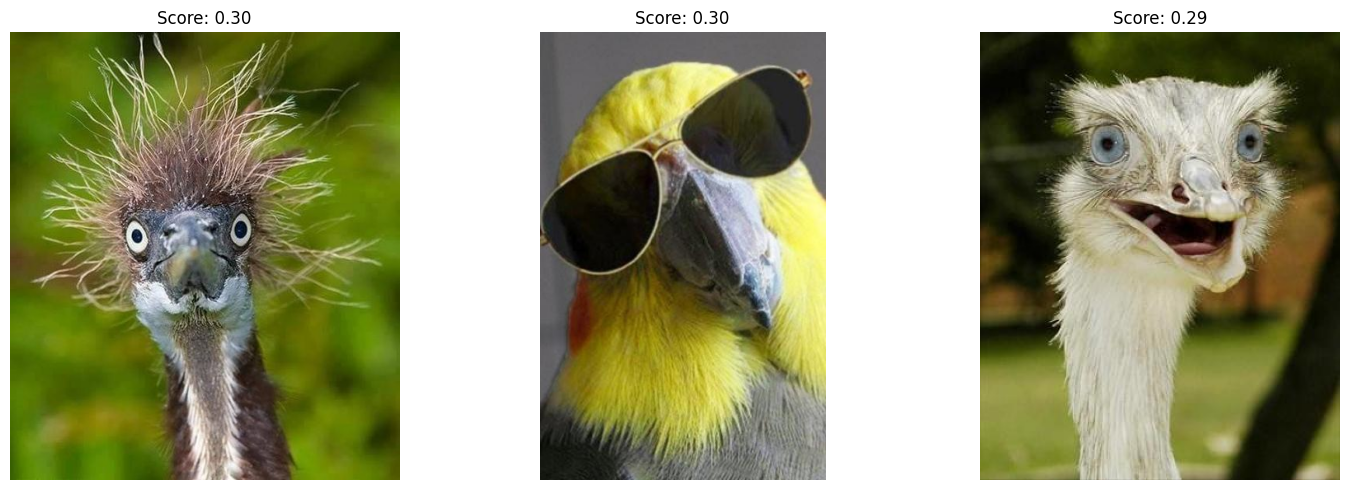

In [8]:
search_text = "funny bird"
query_vector = clip_embd.embed_documents([search_text])[0]
display_top_search_results(query_vector, image_data, num_results=3)

Those look pretty funny to me! Now let's see if it can handle synonyms by searching instead for 'silly bird':

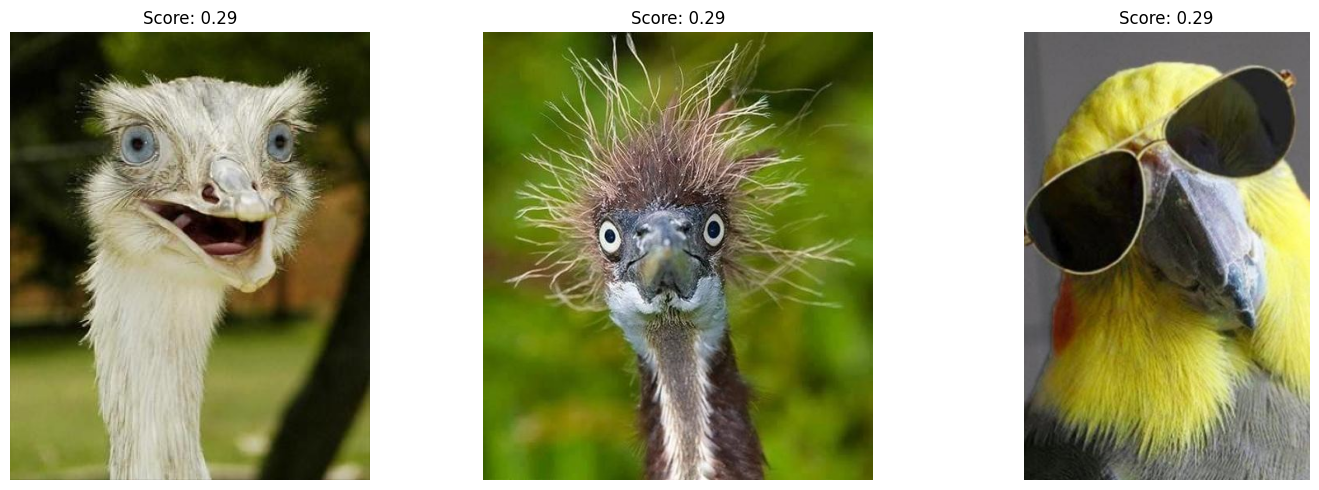

In [9]:
search_text = "silly bird"
query_vector = clip_embd.embed_documents([search_text])[0]
display_top_search_results(query_vector, image_data, num_results=3)

Perfect! Now let's try something much more abstract that would likely never end up in an image tag - 'bad hair day':

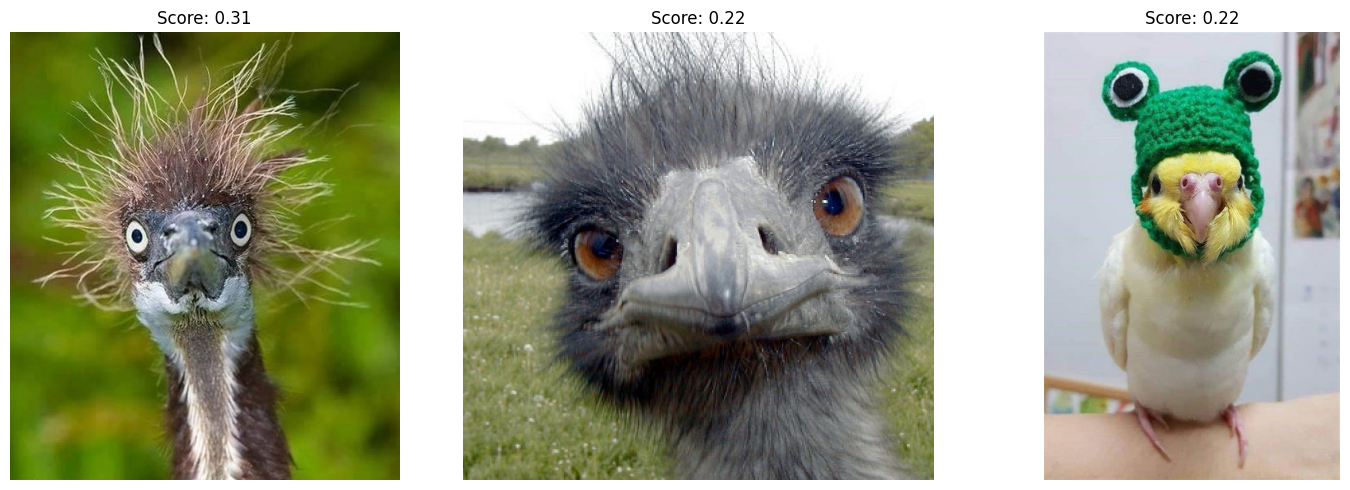

In [10]:
search_text = "bad hair day"
query_vector = clip_embd.embed_documents([search_text])[0]
display_top_search_results(query_vector, image_data, num_results=3)

Our search can even handle this more abstract search pretty well!

#### Reverse Image Search
This setup is actually more flexible than you might think. Remember - as long as we have a search vector in the same meaning space, it doesn't really matter what that vector was made from. It could be made from audio, text, or another image - a vector is a vector! 

Imagine you already have an image, and you want to find images that are similar (perhaps you've taken a picture of a bird and want to look up what species it is). We can do that, and we don't even have to change our function! Here's the image we're going to use for our search:

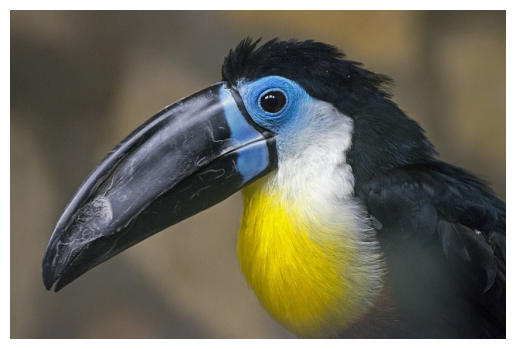

In [12]:
def display_image(image_uri):
    image = PIL.Image.open(image_uri)
    plt.imshow(image)
    plt.axis("off")
    plt.show()

display_image("../../Data/RAG_images/toucan-4185361_640.jpg")

To search for similar images we just create a search vector from this image instead of from a search text:

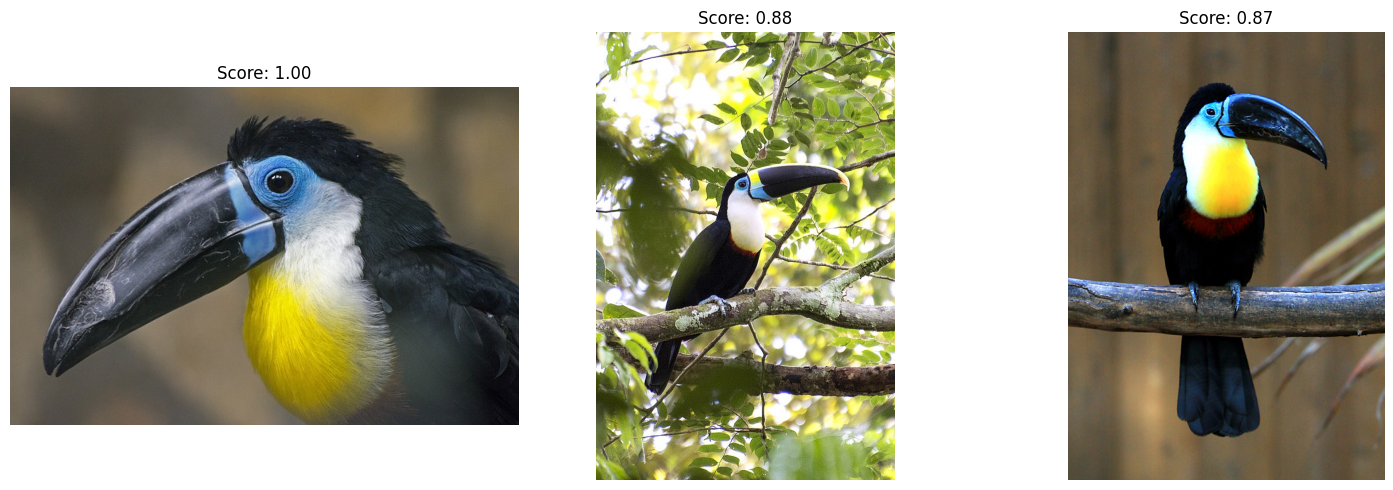

In [13]:
search_image = "../../Data/RAG_images/toucan-4185361_640.jpg"
query_vector = clip_embd.embed_image([search_image])[0]
display_top_search_results(query_vector, image_data, num_results=3)